# Amazon Forecast: predicting time-series at scale

Forecasting is used in a variety of applications and business use cases: For example, retailers need to forecast the sales of their products to decide how much stock they need by location, Manufacturers need to estimate the number of parts required at their factories to optimize their supply chain, Businesses need to estimate their flexible workforce needs, Utilities need to forecast electricity consumption needs in order to attain an efficient energy network, and enterprises need to estimate their cloud infrastructure needs.
<img src="https://amazon-forecast-samples.s3-us-west-2.amazonaws.com/common/images/forecast_overview.png" width="98%">

# Notebook Overview

<img src="https://amazon-forecast-samples.s3-us-west-2.amazonaws.com/common/images/forecast_overview_steps.png" width="98%">

In this notebook we will be walking through the all the steps above.


## Table Of Contents
* Step 1: [Setup Amazon Forecast](#setup)
* Step 2: [Prepare the Datasets](#DataPrep)
* Step 2a: [Prepare and Save the Target Time Series](#DataPrepTTS) 
* Step 2b: [Prepare and save the Related Time Series](#DataPrepRTS) 
* Step 3: [Create the Dataset Group and Dataset](#DataSet)
* Step 4: [Create the Target Time Series Data Import Job](#DataImportTTS)
* Step 5: [Create the Related Time Series Data Import Job](#DataImportRTS)
* Step 6: [Choosing an algorithm and evaluating its performance](#training)
* Step 6b: [Train a Deepar+ Predictor](#trainDeepARP)
* Step 6c: [Train a Prophet Predictor](#trainProphet)
* Step 6d: [Get Predictor Error Metrics from Backtesting](#predictorErrors)
* Step 7: [Create a Forecast](#createForecast)
* Step 8: [Query a Forecast](#queryForecast)
* Step 9: [Export a Forecast](#exportForecast)
* Step 10: [Clean up your Resources](#cleanup)
* [Next Steps](#nextSteps)

For more informations about APIs, please check the [documentation](https://docs.aws.amazon.com/forecast/latest/dg/what-is-forecast.html)


# Step 1: Setup Amazon Forecast<a class="anchor" id="setup"></a>

This section sets up the permissions and relevant endpoints.

In [1]:
import sys
import os

# importing forecast notebook utility from notebooks/common directory
sys.path.insert( 0, os.path.abspath("../../common") )
import util
import util.fcst_utils

%reload_ext autoreload
import boto3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (15.0, 5.0)

Configure the S3 bucket name and region name for this lesson.

- If you don't have an S3 bucket, create it first on S3. 
- Although we have set the region to us-west-2 as a default value below, you can choose any of the regions that the service is available in.

In [2]:
region = boto3.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

# create unique S3 bucket for saving your own data
bucket_name = account_id + '-forecast-demo-bike-small'
if util.create_bucket(bucket_name, region=region):
    print(f"Success! Created bucket {bucket_name}")

In [3]:
# Connect API session
session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')

<b>Create IAM Role for Forecast</b> <br>
Like many AWS services, Forecast will need to assume an IAM role in order to interact with your S3 resources securely. In the sample notebooks, we use the get_or_create_iam_role() utility function to create an IAM role. Please refer to "notebooks/common/util/fcst_utils.py" for implementation.

In [4]:
# Create the role to provide to Amazon Forecast.
role_name = "ForecastNotebookRole-Basic"
print(f"Creating Role {role_name} ...")
role_arn = util.get_or_create_iam_role( role_name = role_name )

# echo user inputs without account
print(f"Success! Created role arn = {role_arn.split('/')[1]}")

# Step 2: Prepare the Datasets<a class="anchor" id="DataPrep"></a>

In [5]:
bike_df = pd.read_csv("data/train.csv", dtype = object)
bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,0,1,1


In [6]:
print(bike_df.datetime.min())
print(bike_df.datetime.max())

2011-01-01 00:00:00
2012-12-19 23:00:00


In [7]:
bike_df['count'] = bike_df['count'].astype('float')
bike_df['workingday'] = bike_df['workingday'].astype('float')

The dataset happens to span January 01, 2011 to Deceber 31, 2012. We are only going to use about two and a half week's of hourly data to train Amazon Forecast.

In [8]:
bike_df_small = bike_df[-2*7*24-24*3:].copy()
bike_df_small['item_id'] = "bike_12"

In [9]:
# save an item_id for querying later
item_id = 'bike_12'

Let us plot the time series first.

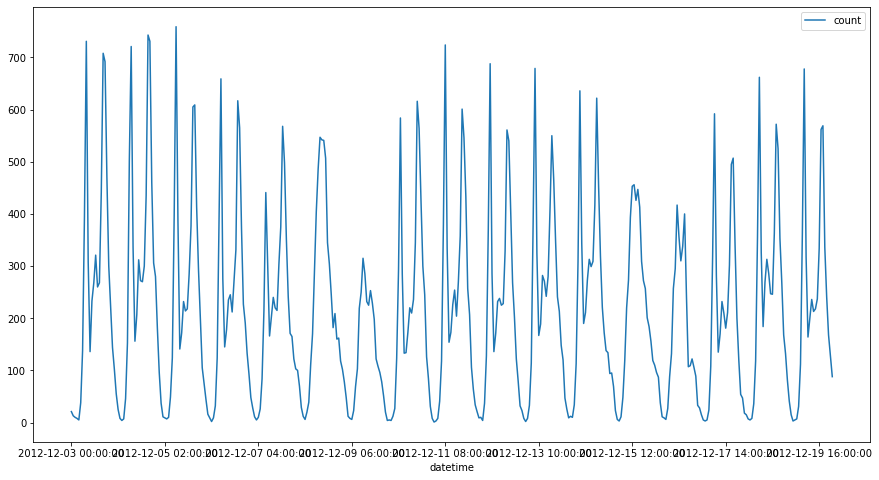

In [10]:
bike_df_small.plot(x='datetime', y='count', figsize=(15, 8))

We can see that the target time series seem to have a drop over weekends. This is a clue for a useful related time series variable.  Let's plot both the target time series and a potential related time series variable `workday` that indicates whether any day is a `workday` or not. 

More precisely, the new related variable `workday`, $r_t = 1$ if $t$ is a work day and 0 if not.

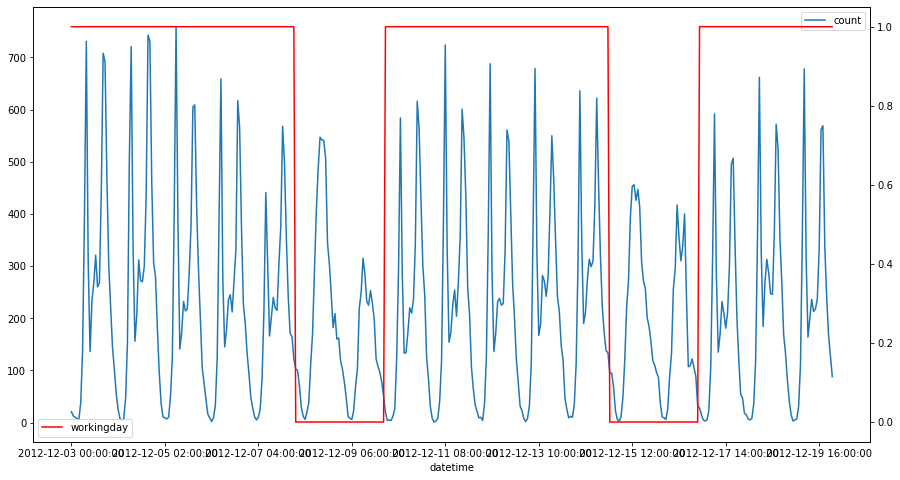

In [11]:
plt.figure(figsize=(15, 8))
ax = plt.gca()
bike_df_small.plot(x='datetime', y='count', ax=ax);
ax2 = ax.twinx()
bike_df_small.plot(x='datetime', y='workingday', color='red', ax=ax2);

## Step 2a: Prepare and Save the Target Time Series<a class="anchor" id="DataPrepTTS"></a>

Below, we specify key input data and forecast parameters

In [13]:
# what is your forecast horizon in number time units you've selected?
# e.g. if you're forecasting in hours, how many months out do you want a forecast?
FORECAST_LENGTH = 24

# What is your forecast time unit granularity?
# Choices are: ^Y|M|W|D|H|30min|15min|10min|5min|1min$ 
DATASET_FREQUENCY = "H"
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"
# delimiter = ','

# What name do you want to give this project?  
# We will use this same name for your Forecast Dataset Group name.
PROJECT = 'small_bike_demo'
DATA_VERSION = 1

In [14]:
target_df = bike_df_small[['item_id', 'datetime', 'count']][:-FORECAST_LENGTH]
target_df.head(5)

,item_id,datetime,count
10478,bike_12,2012-12-03 00:00:00,21.0
10479,bike_12,2012-12-03 01:00:00,13.0
10480,bike_12,2012-12-03 02:00:00,10.0
10481,bike_12,2012-12-03 03:00:00,8.0
10482,bike_12,2012-12-03 04:00:00,5.0


Notice in the output above there are 3 columns of data:

1. An Item ID
1. The Timestamp
1. A Value

These are the 3 key required pieces of information to generate a forecast with Amazon Forecast. More can be added but these 3 must always remain present.


## Step 2b: Prepare and Save the Related Time Series <a class="anchor" id="DataPrepRTS"></a>

To use the related time series, we need to ensure that the related time series covers the whole target time series, as well as the future values as specified by the forecast horizon. More precisely, we need to make sure:
```
len(related time series) >= len(target time series) + forecast horizon
```
Basically, all items need to have data start at or before the item start date, and have data until the forecast horizon (i.e. the latest end date across all items + forecast horizon).  Additionally, there should be no missing values in the related time series. The following picture illustrates the desired logic. 

<img src="images/rts_viz.png">

For more details regarding how to prepare your Related Time Series dataset, please refer to the public documentation <a href="https://docs.aws.amazon.com/forecast/latest/dg/related-time-series-datasets.html">here</a>. 


In [15]:
rts_df = bike_df_small[['item_id', 'datetime', 'workingday']]
rts_df.head(5)

,item_id,datetime,workingday
10478,bike_12,2012-12-03 00:00:00,1.0
10479,bike_12,2012-12-03 01:00:00,1.0
10480,bike_12,2012-12-03 02:00:00,1.0
10481,bike_12,2012-12-03 03:00:00,1.0
10482,bike_12,2012-12-03 04:00:00,1.0


As we can see, the length of the related time series is equal to the length of the target time series plus the forecast horizon. 

In [16]:
print(f"{len(target_df)} + {FORECAST_LENGTH} = {len(rts_df)}")
assert len(target_df) + FORECAST_LENGTH == len(rts_df), "length doesn't match"

384 + 24 = 408


Next we check whether there are "holes" in the related time series.  

In [17]:
assert len(rts_df) == len(pd.date_range(
    start=list(rts_df['datetime'])[0],
    end=list(rts_df['datetime'])[-1],
    freq='H'
)), "missing entries in the related time series"

Everything looks fine, and we plot both time series again. As it can be seen, the related time series (indicator of whether the current day is a workday or not) is longer than the target time series.  The binary working day indicator feature is a good example of a related time series, since it is known at all future time points.  

Other examples of related time series include holiday, price, and promotion features.

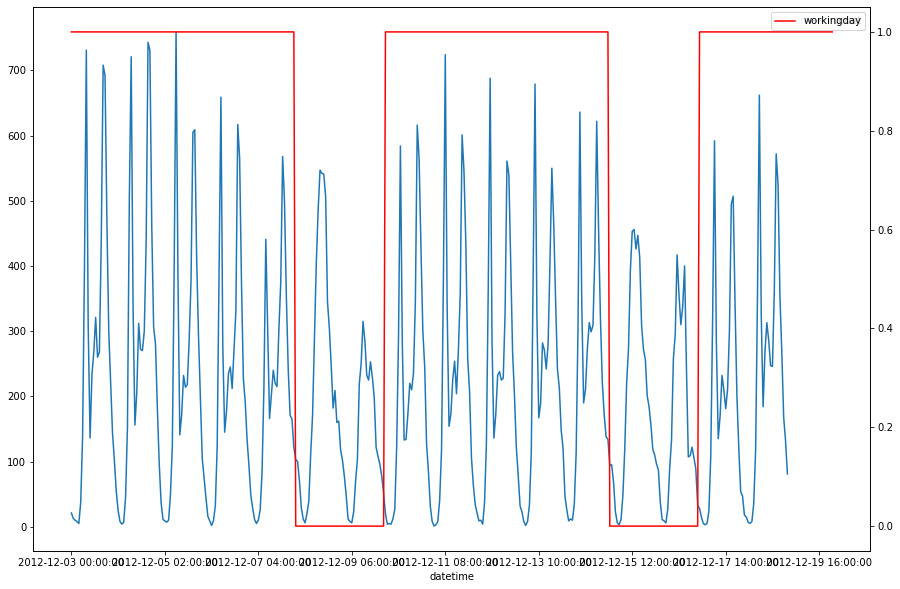

In [18]:
plt.figure(figsize=(15, 10))
ax = plt.gca()
target_df.plot(x='datetime', y='count', ax=ax);
ax2 = ax.twinx()
rts_df.plot(x='datetime', y='workingday', color='red', ax=ax2);

Now export them to CSV files and place them into your `data` folder.

In [19]:
target_df.to_csv("data/bike_small.csv", index= False, header = False)
rts_df.to_csv("data/bike_small_rts.csv", index= False, header = False)

At this time the data is ready to be sent to S3 where Forecast will use it later. The following cells will upload the data to S3.

In [20]:
s3 = session.client('s3')
account_id = boto3.client('sts').get_caller_identity().get('Account')

In [21]:
bucket_name = f"forecast-demo-bike-small-{account_id}"
key = "bike_small"

s3.upload_file(Filename="data/bike_small.csv", Bucket = bucket_name, Key = f"{key}/bike.csv")
s3.upload_file(Filename="data/bike_small_rts.csv", Bucket = bucket_name, Key = f"{key}/bike_rts.csv")

# Step 3: Create the Dataset Group and Dataset<a class="anchor" id="DataSet"></a>
First let's create a dataset group and then update it later to add our datasets.

In Amazon Forecast , a dataset is a collection of file(s) which contain data that is relevant for a forecasting task. A dataset must conform to a schema provided by Amazon Forecast. Since data files are imported headerless, it is important to define a schema for your data.

More details about `Domain` and dataset type can be found on the [documentation](https://docs.aws.amazon.com/forecast/latest/dg/howitworks-domains-ds-types.html) . For this example, we are using [RETAIL](https://docs.aws.amazon.com/forecast/latest/dg/retail-domain.html) domain with 3 required attributes `timestamp`, `target_value` and `item_id`.

### Create the Dataset Group

In this task, we define a container name or Dataset Group name, which will be used to keep track of Dataset import files, schema, and all Forecast results which go together.


In [22]:
dataset_group = f"{PROJECT}_{DATA_VERSION}"
print(f"Dataset Group Name = {dataset_group}")

Dataset Group Name = small_bike_demo_1


In [23]:
dataset_arns = []
create_dataset_group_response = \
    forecast.create_dataset_group(Domain="RETAIL",
                                  DatasetGroupName=dataset_group,
                                  DatasetArns=dataset_arns)

In [24]:
dataset_group_arn = create_dataset_group_response['DatasetGroupArn']

In [ ]:
forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

### Create the Target Schema

Next, we specify the schema of our dataset below. Make sure the order of the attributes (columns) matches the raw data in the files. 

In [26]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
ts_schema ={
   "Attributes":[
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"demand",
         "AttributeType":"float"
      }
   ]
}

### Create a Target Dataset 

Target is a required dataset to use the service.

In [27]:
ts_dataset_name = f"{PROJECT}_{DATA_VERSION}_tts"
print(ts_dataset_name)

small_bike_demo_1_tts


In [28]:
response = \
    forecast.create_dataset(Domain="RETAIL",
                            DatasetType='TARGET_TIME_SERIES',
                            DatasetName=ts_dataset_name,
                            DataFrequency=DATASET_FREQUENCY,
                            Schema=ts_schema
                           )

In [29]:
ts_dataset_arn = response['DatasetArn']

In [ ]:
forecast.describe_dataset(DatasetArn=ts_dataset_arn)

### Create the Related Schema
Make sure the order of the attributes (columns) matches the raw data in the files. 

In [31]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
rts_schema ={
   "Attributes":[
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"workingday",
         "AttributeType":"float"
      }
   ]
}

### Create a Related Dataset 

In this example, we will define a related time series.

In [32]:
rts_dataset_name = f"{PROJECT}_{DATA_VERSION}_rts"
print(rts_dataset_name)

small_bike_demo_1_rts


In [33]:
response = \
    forecast.create_dataset(Domain="RETAIL",
                            DatasetType='RELATED_TIME_SERIES',
                            DatasetName=rts_dataset_name,
                            DataFrequency=DATASET_FREQUENCY,
                            Schema=rts_schema
                           )

In [34]:
rts_dataset_arn = response['DatasetArn']

In [ ]:
forecast.describe_dataset(DatasetArn=rts_dataset_arn)

### Update the dataset group with the datasets we created 

You can have multiple datasets under the same dataset group. Update it with the datasets we created before.

In [36]:
dataset_arns = []
dataset_arns.append(ts_dataset_arn)
dataset_arns.append(rts_dataset_arn)
forecast.update_dataset_group(DatasetGroupArn=dataset_group_arn, DatasetArns=dataset_arns)

{'ResponseMetadata': {'RequestId': 'bf7a8cb4-ac53-429e-97c2-749078eb4e41',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 11 Mar 2021 01:01:44 GMT',
   'x-amzn-requestid': 'bf7a8cb4-ac53-429e-97c2-749078eb4e41',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [ ]:
forecast.describe_dataset_group(DatasetGroupArn=dataset_group_arn)

# Step 4. Create the Target Time Series Data Import Job<a class="anchor" id="DataImportTTS"></a>

Now that Forecast knows how to understand the CSV we are providing, the next step is to import the data from S3 into Amazon Forecast.

In [38]:
s3_data_path = f"s3://{bucket_name}/{key}"

In [39]:
ts_s3_data_path = f"{s3_data_path}/bike.csv"

In [40]:
ts_dataset_import_job_response = \
    forecast.create_dataset_import_job(DatasetImportJobName=dataset_group,
                                       DatasetArn=ts_dataset_arn,
                                       DataSource= {
                                         "S3Config" : {
                                             "Path": ts_s3_data_path,
                                             "RoleArn": role_arn
                                         } 
                                       },
                                       TimestampFormat=TIMESTAMP_FORMAT)

In [41]:
ts_dataset_import_job_arn=ts_dataset_import_job_response['DatasetImportJobArn']

Check the status of dataset, when the status change from **CREATE_IN_PROGRESS** to **ACTIVE**, we can continue to next steps. Depending on the data size. It can take 10 mins to be **ACTIVE**. This process will take 5 to 10 minutes.

In [42]:
status = util.wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))
assert status

CREATE_PENDING ..
CREATE_IN_PROGRESS ..........................................
ACTIVE 


# Step 5. Create a Related Time Series Data Import Job<a class="anchor" id="DataImportRTS"></a>

In [43]:
rts_s3_data_path = f"{s3_data_path}/bike_rts.csv"

In [44]:
rts_dataset_import_job_response = \
    forecast.create_dataset_import_job(DatasetImportJobName=dataset_group,
                                       DatasetArn=rts_dataset_arn,
                                       DataSource= {
                                         "S3Config" : {
                                             "Path": rts_s3_data_path,
                                             "RoleArn": role_arn
                                         } 
                                       },
                                       TimestampFormat=TIMESTAMP_FORMAT)

In [45]:
rts_dataset_import_job_arn=rts_dataset_import_job_response['DatasetImportJobArn']

Check the status of dataset, when the status change from **CREATE_IN_PROGRESS** to **ACTIVE**, we can continue to next steps. Depending on the data size. It can take 10 mins to be **ACTIVE**. This process will take 5 to 10 minutes.

In [46]:
status = util.wait(lambda: forecast.describe_dataset_import_job(DatasetImportJobArn=rts_dataset_import_job_arn))
assert status

CREATE_PENDING ..
CREATE_IN_PROGRESS ............
ACTIVE 


# Step 6. Choosing an algorithm and evaluating its performance<a class="anchor" id="training"></a>

Once the datasets are specified with the corresponding schema, Amazon Forecast will automatically aggregate, at the specified time granularity, all the relevant pieces of information for each item, such as sales, price, promotions, as well as categorical attributes, and generate the desired dataset. Next, one can choose an algorithm (forecasting model) and evaluate how well this particular algorithm works on this dataset. The following graph gives a high-level overview of the forecasting models.
<img src="https://amazon-forecast-samples.s3-us-west-2.amazonaws.com/common/images/recipes.png" width="98%">
<img src="https://amazon-forecast-samples.s3-us-west-2.amazonaws.com/common/images/mqcnn.png" width="70%">
<img src="https://amazon-forecast-samples.s3-us-west-2.amazonaws.com/common/images/pred_details.png">


Amazon Forecast provides several state-of-the-art forecasting algorithms including classic forecasting methods such as ETS, ARIMA, Prophet and deep learning approaches such as DeepAR+. Classical forecasting methods, such as Autoregressive Integrated Moving Average (ARIMA) or Exponential Smoothing (ETS), fit a single model to each individual time series, and then use that model to extrapolate the time series into the future. Amazon's Non-Parametric Time Series (NPTS) forecaster also fits a single model to each individual time series.  Unlike the naive or seasonal naive forecasters that use a fixed time index (the previous index $T-1$ or the past season $T - \tau$) as the prediction for time step $T$, NPTS randomly samples a time index $t \in \{0, \dots T-1\}$ in the past to generate a sample for the current time step $T$.

In many applications, you may encounter many similar time series across a set of cross-sectional units. Examples of such time series groupings are demand for different products, server loads, and requests for web pages. In this case, it can be beneficial to train a single model jointly over all of these time series. CNN-QR and DeepAR+ take this approach, outperforming the standard ARIMA and ETS methods when your dataset contains hundreds of related time series. The trained model can also be used for generating forecasts for new time series that are similar to the ones it has been trained on. 

While deep learning approaches can outperform standard methods, this is only possible when there is sufficient data available for training. It is not true for example when one trains a neural network with a time-series containing only a few dozen observations. Amazon Forecast provides the best of two worlds allowing users to either choose a specific algorithm or let Amazon Forecast automatically perform model selection. 


## How to evaluate a forecasting model?

Before moving forward, let's first introduce the notion of *backtest* when evaluating forecasting models. The key difference between evaluating forecasting algorithms and standard ML applications is that we need to make sure there is no future information gets used in the past. In other words, the procedure needs to be causal. 

<img src="https://amazon-forecast-samples.s3-us-west-2.amazonaws.com/common/images/backtest.png" width=70%>


In this notebook, let's compare the neural network based method, DeepAR+ with Facebook's open-source Bayesian method Prophet.

## Step 6a. Train a DeepAR+ Predictor<a class="anchor" id="trainDeepARP"></a>

In [48]:
# Which algorithm do you want to use?  Choices are:
# 1. Choose PerformAutoML=True if you want to let Amazon Forecast choose a recipe automatically.  
# 2. If you know which recipe you want, the next level of automation is PerformHPO=True.
# 3. Finally, you can specify exactly which recipe and enter your own hyperparameter values
# https://docs.aws.amazon.com/forecast/latest/dg/aws-forecast-choosing-recipes.html

algorithm_arn = 'arn:aws:forecast:::algorithm/'
algorithm = 'Deep_AR_Plus'
algorithm_arn_deep_ar_plus = algorithm_arn + algorithm
predictor_name_deep_ar = f"{PROJECT}_{DATA_VERSION}_{algorithm.lower()}"
print(f"Predictor Name = {predictor_name_deep_ar}")

Predictor Name = small_bike_demo_1_deep_ar_plus


In [49]:
create_predictor_response = \
    forecast.create_predictor(PredictorName=predictor_name_deep_ar,
                              AlgorithmArn=algorithm_arn_deep_ar_plus,
                              ForecastHorizon=FORECAST_LENGTH,
                              PerformAutoML=False,
                              PerformHPO=False,
                              InputDataConfig= {"DatasetGroupArn": dataset_group_arn},
                              FeaturizationConfig= {"ForecastFrequency": DATASET_FREQUENCY}
                             )

In [50]:
predictor_arn_deep_ar = create_predictor_response['PredictorArn']

Check the status of the predictor. When the status change from **CREATE_IN_PROGRESS** to **ACTIVE**, we can continue to next steps. Depending on data size, model selection and choice of hyper parameters tuning，it can take several hours to be **ACTIVE**.

In [51]:
status = util.wait(lambda: forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar))
assert status

CREATE_PENDING ..
CREATE_IN_PROGRESS ..................................................................................................................................................................
ACTIVE 


In [ ]:
forecast.describe_predictor(PredictorArn=predictor_arn_deep_ar)

## Step 6b.  Train a Prophet Predictor <a class="anchor" id="trainProphet"></a>

In [53]:
# Which algorithm do you want to use?  Choices are:
# 1. Choose PerformAutoML=True if you want to let Amazon Forecast choose a recipe automatically.  
# 2. If you know which recipe you want, the next level of automation is PerformHPO=True.
# 3. Finally, you can specify exactly which recipe and enter your own hyperparameter values
# https://docs.aws.amazon.com/forecast/latest/dg/aws-forecast-choosing-recipes.html

algorithm = 'Prophet'
algorithm_arn_prophet = algorithm_arn + algorithm
# predictor_name_prophet = f'{project}_{algorithm.lower()}_{idx}'
predictor_name_prophet = f"{PROJECT}_{DATA_VERSION}_{algorithm.lower()}"
print(f"Predictor Name = {predictor_name_prophet}")

Predictor Name = small_bike_demo_1_prophet


In [54]:
create_predictor_response = \
    forecast.create_predictor(PredictorName=predictor_name_prophet,
                              AlgorithmArn=algorithm_arn_prophet,
                              ForecastHorizon=FORECAST_LENGTH,
                              PerformAutoML=False,
                              PerformHPO=False,
                              InputDataConfig= {"DatasetGroupArn": dataset_group_arn},
                              FeaturizationConfig= {"ForecastFrequency": DATASET_FREQUENCY}
                             )

In [55]:
predictor_arn_prophet = create_predictor_response['PredictorArn']

Check the status of the predictor. When the status change from **CREATE_IN_PROGRESS** to **ACTIVE**, we can continue to next steps. Depending on data size, model selection and choice of hyper parameters tuning，it can take several hours to be **ACTIVE**.

In [56]:
status = util.wait(lambda: forecast.describe_predictor(PredictorArn=predictor_arn_prophet))
assert status

CREATE_PENDING 
CREATE_IN_PROGRESS ..............................................................................
ACTIVE 


In [ ]:
forecast.describe_predictor(PredictorArn=predictor_arn_prophet)

## Step 6d. Get Predictor Error Metrics from Backtesting <a class="anchor" id="predictorErrors"></a>

After creating the predictors, we can query the errors given by the backtest scenario and have a quantitative understanding of the performance of the algorithm. During model development, it is common to experiment and produce different predictors.  By comparing error metrics from the different predictors, data scientists typically iterate to decide the best model or predictor to use before deploying it into a production environment.  

In the cells below, we get the predictor error metrics and show a plot of different quantile forecasts for 2 different predictors. 

We're not demoing it in this notebook, but there is also an Export Predictor Backtest files job you can trigger.  This will save Predictor Error Metrics and also save Item-level Backtest Forecasts to an S3 bucket of your choice.  This is useful in case you want to use custom metric calculations on particular groups of items.
<a href="https://github.com/aws-samples/amazon-forecast-samples/tree/master/notebooks/advanced/Item_Level_Accuracy" target="_blank">See advanced/Item_Level_Accuracy notebook</a>
<br>
<br>

In [58]:
error_metrics_deep_ar_plus = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_deep_ar)
error_metrics_deep_ar_plus

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 63.24519538067048,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.34116184525897786},
       {'Quantile': 0.5, 'LossValue': 0.21760683308697137},
       {'Quantile': 0.1, 'LossValue': 0.06909328030448082}],
      'ErrorMetrics': [{'ForecastType': 'mean',
        'WAPE': 0.21776453877435673,
        'RMSE': 63.24519538067048}]}},
    {'TestWindowStart': datetime.datetime(2012, 12, 17, 16, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2012, 12, 18, 16, 0, tzinfo=tzlocal()),
     'ItemCount': 1,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 63.24519538067048,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.34116184525897786},
       {'Quantile': 0.5, 'LossValue': 0.21760683308697137},
       {'Quantile': 0.1, 'LossValue': 0.06909328030448082}

In [59]:
error_metrics_prophet = forecast.get_accuracy_metrics(PredictorArn=predictor_arn_prophet)
error_metrics_prophet

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Prophet',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 82.40197311195215,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.16673234455179423},
       {'Quantile': 0.5, 'LossValue': 0.25200177436441146},
       {'Quantile': 0.1, 'LossValue': 0.10950048752919009}],
      'ErrorMetrics': [{'ForecastType': 'mean',
        'WAPE': 0.2463561131677546,
        'RMSE': 82.40197311195215}]}},
    {'TestWindowStart': datetime.datetime(2012, 12, 17, 16, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2012, 12, 18, 16, 0, tzinfo=tzlocal()),
     'ItemCount': 1,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 82.40197311195215,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.16673234455179423},
       {'Quantile': 0.5, 'LossValue': 0.25200177436441146},
       {'Quantile': 0.1, 'LossValue': 0.10950048752919009}],
   

In [60]:
def extract_summary_metrics(metric_response, predictor_name):
    df = pd.DataFrame(metric_response['PredictorEvaluationResults']
                 [0]['TestWindows'][0]['Metrics']['WeightedQuantileLosses'])
    df['Predictor'] = predictor_name
    return df

In [61]:
deep_ar_metrics = extract_summary_metrics(error_metrics_deep_ar_plus, "DeepAR")
prophet_metrics = extract_summary_metrics(error_metrics_prophet, "Prophet")

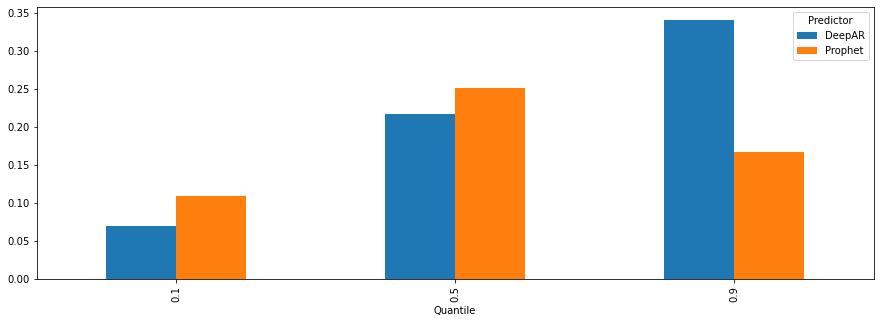

In [62]:
pd.concat([deep_ar_metrics, prophet_metrics]) \
    .pivot(index='Quantile', columns='Predictor', values='LossValue').plot.bar();

As we mentioned before, if you only have a handful of time series (in this case, only 1) with a small number of examples, the neural network models (DeepAR+) are not the best choice. Here, we clearly see that DeepAR+ behaves worse than Prophet in the case of a single time series. 

# Step 7. Create a Forecast <a class="anchor" id="createForecast"></a>

In [63]:
forecast_name_deep_ar = f"{PROJECT}_{DATA_VERSION}_deeparp"
print(f"Forecast Name = {forecast_name_deep_ar}")

Forecast Name = small_bike_demo_1_deeparp


In [64]:
create_forecast_response_deep_ar = forecast.create_forecast(ForecastName=forecast_name_deep_ar,
                                                        PredictorArn=predictor_arn_deep_ar)

In [65]:
forecast_arn_deep_ar = create_forecast_response_deep_ar['ForecastArn']

In [66]:
status = util.wait(lambda: forecast.describe_forecast(ForecastArn=forecast_arn_deep_ar))
assert status

CREATE_PENDING ..
CREATE_IN_PROGRESS ...............................................................
ACTIVE 


In [ ]:
forecast.describe_forecast(ForecastArn=forecast_arn_deep_ar)

In [68]:
forecast_name_prophet = f"{PROJECT}_{DATA_VERSION}_prophet"
print(f"Forecast Name = {forecast_name_prophet}")

Forecast Name = small_bike_demo_1_prophet


In [69]:
create_forecast_response_prophet = forecast.create_forecast(ForecastName=forecast_name_prophet,
                                                        PredictorArn=predictor_arn_prophet)

In [70]:
forecast_arn_prophet = create_forecast_response_prophet['ForecastArn']

Check the status of the forecast process, when the status change from **CREATE_IN_PROGRESS** to **ACTIVE**, we can continue to next steps. Depending on data size, model selection and choice of hyper parameters tuning，it can take several hours to be **ACTIVE**.

In [71]:
status = util.wait(lambda: forecast.describe_forecast(ForecastArn=forecast_arn_prophet))
assert status

CREATE_PENDING .
CREATE_IN_PROGRESS ..............................................................
ACTIVE 


In [ ]:
forecast.describe_forecast(ForecastArn=forecast_arn_prophet)

# Step 8. Query a Forecast<a class="anchor" id="queryForecast"></a>

Once created, the forecast results are ready and you view them. 

In [73]:
item_id

'bike_12'

In [74]:
forecast_response_deep = forecastquery.query_forecast(
    ForecastArn=forecast_arn_deep_ar,
    Filters={"item_id": item_id})

In [75]:
forecast_response_prophet = forecastquery.query_forecast(ForecastArn=forecast_arn_prophet,
                                                     Filters={"item_id":item_id})

In [76]:
fname = f'data/bike_small.csv'
exact = util.load_exact_sol(fname, item_id)

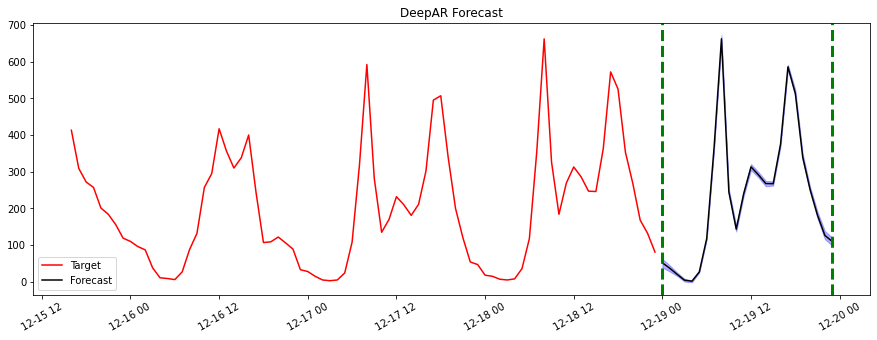

In [78]:
util.plot_forecasts(forecast_response_deep, exact)
plt.title("DeepAR Forecast");

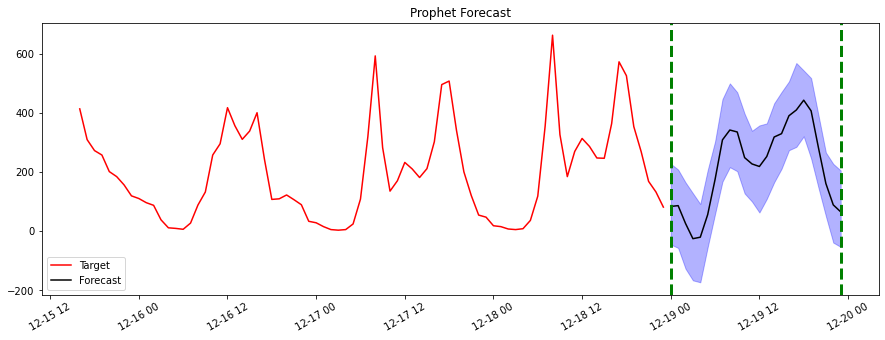

In [79]:
util.plot_forecasts(forecast_response_prophet,exact)
plt.title("Prophet Forecast");

# Step 9. Export a Forecast<a class="anchor" id="exportForecast"></a>

Forecasts can be exported to your own S3 bucket of choice.  You may need to use these in downstream Supply Chain processes.  Or, perhaps you just want to import them into a BI tool to visualize and socialize the results.

In [ ]:
forecast_export_name_deep_ar = f"{PROJECT}_{DATA_VERSION}_forecast_export_deeparp"
forecast_export_name_deep_ar_path = f"{s3_data_path}/{forecast_export_name_deep_ar}"

In [ ]:
create_forecast_export_response_deep_ar = \
    forecast.create_forecast_export_job(ForecastExportJobName=forecast_export_name_deep_ar,
                                        ForecastArn=forecast_arn_deep_ar,
                                        Destination={
                                            "S3Config" : {
                                                "Path": forecast_export_name_deep_ar_path,
                                                "RoleArn": role_arn
                                            }
                                        })
forecast_export_arn_deep_ar = create_forecast_export_response_deep_ar['ForecastExportJobArn']

In [ ]:
forecast_export_name_prophet = f"{PROJECT}_{DATA_VERSION}_forecast_export_prophet"
forecast_export_name_prophet_path = f"{s3_data_path}/{forecast_export_name_prophet}"

In [ ]:
create_forecast_export_response_prophet = \
    forecast.create_forecast_export_job(ForecastExportJobName=forecast_export_name_prophet,
                                        ForecastArn=forecast_arn_prophet,
                                        Destination={
                                            "S3Config" : {
                                                "Path": forecast_export_name_prophet_path,
                                                "RoleArn": role_arn
                                            }
                                        })
forecast_export_arn_prophet = create_forecast_export_response_prophet['ForecastExportJobArn']

# Step 10. Clean up your Resources<a class="anchor" id="cleanup"></a>

Once we have completed the above steps, we can start to cleanup the resources we created. All delete jobs, except for `delete_dataset_group` are asynchronous, so we have added the helpful `wait_till_delete` function. 
Resource Limits documented <a href="https://docs.aws.amazon.com/forecast/latest/dg/limits.html">here</a>. 

In [ ]:
# Delete forecast export for both algorithms
util.wait_till_delete(lambda: forecast.delete_forecast_export_job(ForecastExportJobArn = forecast_export_arn_deep_ar))
util.wait_till_delete(lambda: forecast.delete_forecast_export_job(ForecastExportJobArn = forecast_export_arn_prophet))

In [ ]:
# Delete forecast for both algorithms
util.wait_till_delete(lambda: forecast.delete_forecast(ForecastArn = forecast_arn_deep_ar))
util.wait_till_delete(lambda: forecast.delete_forecast(ForecastArn = forecast_arn_prophet))

In [ ]:
# Delete predictor for both algorithms
util.wait_till_delete(lambda: forecast.delete_predictor(PredictorArn = predictor_arn_deep_ar))
util.wait_till_delete(lambda: forecast.delete_predictor(PredictorArn = predictor_arn_prophet))

In [ ]:
# Delete the target time series and related time series dataset import jobs
util.wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn=ts_dataset_import_job_arn))
util.wait_till_delete(lambda: forecast.delete_dataset_import_job(DatasetImportJobArn=rts_dataset_import_job_arn))

In [ ]:
# Delete the target time series and related time series datasets
util.wait_till_delete(lambda: forecast.delete_dataset(DatasetArn=ts_dataset_arn))
util.wait_till_delete(lambda: forecast.delete_dataset(DatasetArn=rts_dataset_arn))

In [ ]:
# Delete dataset group
util.wait_till_delete(lambda: forecast.delete_dataset_group(DatasetGroupArn=dataset_group_arn))

## Next Steps<a class="anchor" id="nextSteps"></a>

Congratulations!! You've trained your first Amazon Forecast model and generated your first forecast!!

To dive deeper, here are a couple options for further evaluation:
<ul>
    <li>Example how to use a notebook and Predictor Backtest Forecasts to evaluate all items at once using custom metrics: <a href="https://github.com/aws-samples/amazon-forecast-samples/tree/master/notebooks/advanced/Item_Level_Accuracy" target="_blank">Item_Level_Accuracy notebook</a></li>
    <li>Example how to use our built-in, hosted-by-AWS weather data: <a href="https://github.com/aws-samples/amazon-forecast-samples/blob/master/notebooks/advanced/Weather_index/1.%20Training%20your%20model%20with%20Weather%20Index.ipynb" target="_blank">Training your model with Weather Index </a></li>
    <li>Finally, for a production-level example, how to use Amazon QuickSight to visualize either Predictor Backtest Forecasts and/or Forecasts so you can share and socialize the results with others <a href="https://aws.amazon.com/solutions/implementations/improving-forecast-accuracy-with-machine-learning/?did=sl_card&trk=sl_card" target="_blank">see our automation solution Improving Forecast Accuracy</a></li>
    <li><a href="https://console.aws.amazon.com/cloudformation/home?region=us-east-1#/stacks/new?stackName=forecast-stack&t[…]acy-with-machine-learning-demo.template" target="_blank">Quick launch link for above automation</a></li>
    </ul>